shift +cmd+ i to bring the copilot chat

⚠️ Exit threshold not found — not plotted.
⚠️ Entry threshold not found — not plotted.


/Users/jayren/Desktop/Pair Trading/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:1286: RuntimeWarning: overflow encountered in divide
  out[tuple(slice1)] = (f[tuple(slice4)] - f[tuple(slice2)]) / (2. * ax_dx)
/Users/jayren/Desktop/Pair Trading/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:1286: RuntimeWarning: overflow encountered in subtract
  out[tuple(slice1)] = (f[tuple(slice4)] - f[tuple(slice2)]) / (2. * ax_dx)
/var/folders/zv/byjsmvy90d57p6xyyc10dt240000gn/T/ipykernel_15524/1777856950.py:22: RuntimeWarning: overflow encountered in multiply
  return kappa * (theta - E) * d1 + 0.5 * sigma**2 * d2
/var/folders/zv/byjsmvy90d57p6xyyc10dt240000gn/T/ipykernel_15524/1777856950.py:22: RuntimeWarning: invalid value encountered in add
  return kappa * (theta - E) * d1 + 0.5 * sigma**2 * d2
/var/folders/zv/byjsmvy90d57p6xyyc10dt240000gn/T/ipykernel_15524/1777856950.py:29: RuntimeWarning: invalid value encountered in add
  H_new = H + 0.1 * (np.ma

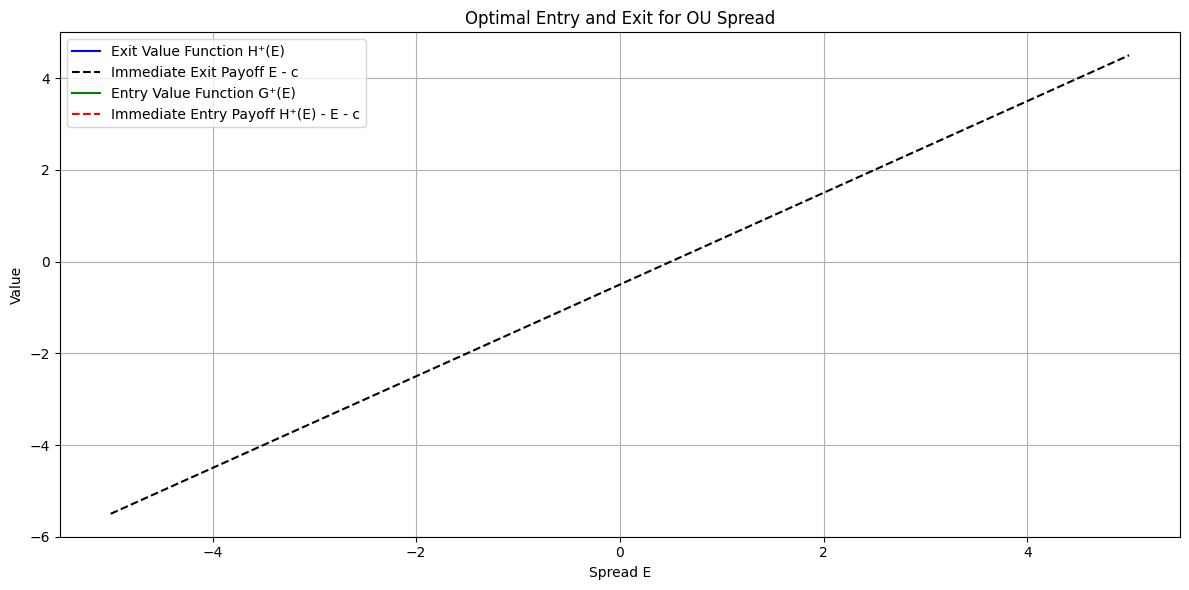

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
kappa = 1.0    # mean-reversion speed
theta = 0.0    # long-run mean of spread
sigma = 1.0    # volatility of the spread
rho = 0.05     # discount rate (urgency of action)
c = 0.5        # transaction cost


# Grid setup, create a grid of E values, used for finite difference approximation of derivatives

E_min, E_max = -5, 5
N = 500
E = np.linspace(E_min, E_max, N)
dE = E[1] - E[0]

# Infinitesimal generator operator
def L(v):
    d1 = np.gradient(v, dE)
    d2 = np.gradient(d1, dE)
    return kappa * (theta - E) * d1 + 0.5 * sigma**2 * d2

# ---- Solve Exit Problem: H+(E) ----H: value after entry
H = np.maximum(E - c, 0)  # initial guess: immediate exercise value

# Iteratively solve the VI
for _ in range(5000):
    H_new = H + 0.1 * (np.maximum(E - c - H, (L(H) - rho * H)))
    # E-c if it is optimal to exit now, rho* H if it is optimal to wait, that is L(H)=rho*H
    if np.max(np.abs(H_new - H)) < 1e-6:
        break
    H = H_new

# ---- Solve Entry Problem: G+(E) ----value before entry
G = np.maximum(H - E - c, 0)  # initial guess

for _ in range(5000):
    G_new = G + 0.1 * (np.maximum(H - E - c - G, (L(G) - rho * G)))
    if np.max(np.abs(G_new - G)) < 1e-6:
        break
    G = G_new

# ---- Identify Thresholds ----
tol = 1e-2
exit_candidates = np.where(np.abs(H - (E - c)) < tol)[0]
entry_candidates = np.where(np.abs(G - (H - E - c)) < tol)[0]

exit_threshold = E[exit_candidates[0]] if len(exit_candidates) > 0 else None
entry_threshold = E[entry_candidates[-1]] if len(entry_candidates) > 0 else None

# ---- Plotting ----
plt.figure(figsize=(12, 6))

plt.plot(E, H, label='Exit Value Function H⁺(E)', color='blue')
plt.plot(E, E - c, 'k--', label='Immediate Exit Payoff E - c')
if exit_threshold is not None:
    plt.axvline(exit_threshold, color='blue', linestyle=':', label=f'Exit Threshold: {exit_threshold:.2f}')
else:
    print("⚠️ Exit threshold not found — not plotted.")

plt.plot(E, G, label='Entry Value Function G⁺(E)', color='green')
plt.plot(E, H - E - c, 'r--', label='Immediate Entry Payoff H⁺(E) - E - c')
if entry_threshold is not None:
    plt.axvline(entry_threshold, color='green', linestyle=':', label=f'Entry Threshold: {entry_threshold:.2f}')
else:
    print("⚠️ Entry threshold not found — not plotted.")

plt.title('Optimal Entry and Exit for OU Spread')
plt.xlabel('Spread E')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

[*********************100%***********************]  2 of 2 completed

Estimated OU Parameters:
kappa: nan
theta: -0.0118
sigma: nan



/var/folders/zv/byjsmvy90d57p6xyyc10dt240000gn/T/ipykernel_15524/947122925.py:26: RuntimeWarning: invalid value encountered in log
  kappa = -np.log(phi) / delta_t


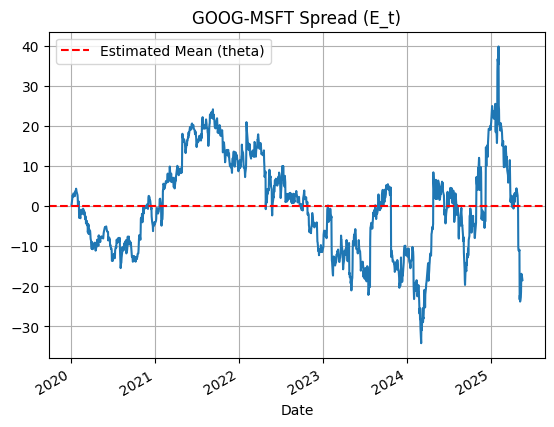

In [52]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Step 1: Download historical data
tickers = ['GOOG', 'MSFT']
data = yf.download(tickers, start='2020-01-01', end='2025-12-31')['Close'].dropna()

# Step 2: Estimate the spread (co-integration residual)
X = sm.add_constant(data['MSFT'])
model = sm.OLS(data['GOOG'], X).fit()
spread = data['GOOG'] - model.predict(X)  # this is E_t

# Step 3: Estimate OU parameters from discretized process
spread_diff = spread.diff().dropna()
spread_lag = spread.shift(1).dropna().loc[spread_diff.index]

reg = sm.OLS(spread_diff, sm.add_constant(spread_lag)).fit()

phi = reg.params[0]

delta_t = 1  # assuming daily returns

kappa = -np.log(phi) / delta_t
theta = reg.params[0] / (1 - phi)
residuals = reg.resid
sigma = np.std(residuals) * np.sqrt(2 * kappa / (1 - phi**2))

# Output parameters
print("Estimated OU Parameters:")
print(f"kappa: {kappa:.4f}")
print(f"theta: {theta:.4f}")
print(f"sigma: {sigma:.4f}")

# Optional: Plot the spread
spread.plot(title='GOOG-MSFT Spread (E_t)')
plt.axhline(theta, color='red', linestyle='--', label='Estimated Mean (theta)')
plt.legend()
plt.grid(True)
plt.show()


In [50]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Step 1: Download historical data
tickers = ['GOOG', 'MSFT']
data = yf.download(tickers, start='2020-01-01', end='2024-12-31')['Close'].dropna()

# Step 2: Estimate the spread (co-integration residual)
X = sm.add_constant(data['MSFT'])
model = sm.OLS(data['GOOG'], X).fit()
spread = data['GOOG'] - model.predict(X)  # this is E_t

# Step 3: Estimate OU parameters from discretized process
spread_diff = spread.diff().dropna()
spread_lag = spread.shift(1).dropna().loc[spread_diff.index]

reg = sm.OLS(spread_diff, sm.add_constant(spread_lag)).fit()
print(reg.params)

print(reg.summary())

[*********************100%***********************]  2 of 2 completed

const    0.017993
0       -0.009957
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     5.434
Date:                Mon, 19 May 2025   Prob (F-statistic):             0.0199
Time:                        16:28:49   Log-Likelihood:                -2460.9
No. Observations:                1256   AIC:                             4926.
Df Residuals:                    1254   BIC:                             4936.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c